In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.metrics import mean_squared_error
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Данные

In [2]:
df = pd.read_csv('yahoo_stock.csv')

df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [4]:
# Создаем временной ряд с датой и закрывающей ценой
time_series = df[['Date', 'Close']].copy()

time_series['Date'] = pd.to_datetime(time_series['Date'])
time_series.set_index('Date', inplace=True)
print(time_series.head())

                  Close
Date                   
2015-11-23  2086.590088
2015-11-24  2089.139893
2015-11-25  2088.870117
2015-11-26  2088.870117
2015-11-27  2090.110107


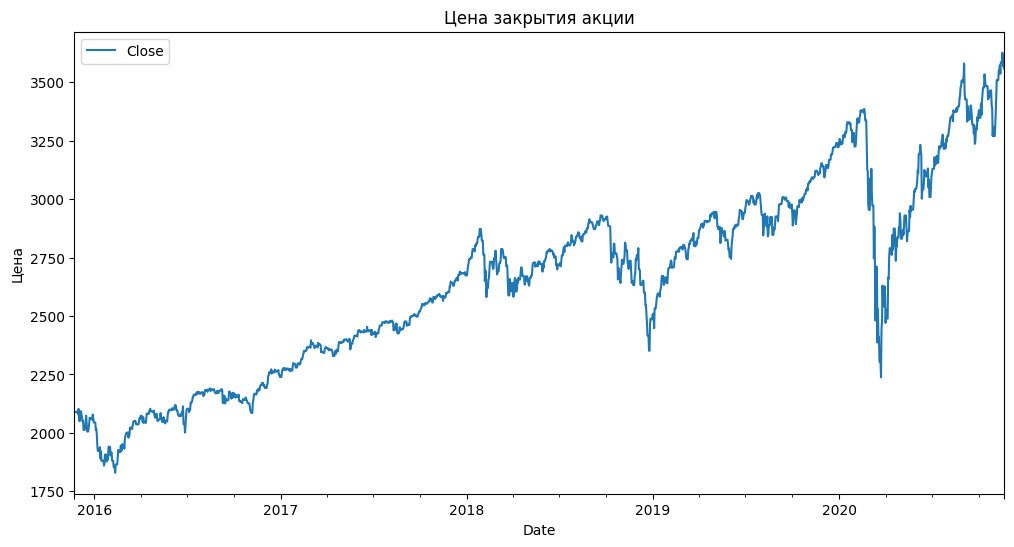

In [5]:
import matplotlib.pyplot as plt
time_series.plot(figsize=(12, 6))
plt.title('Цена закрытия акции')
plt.ylabel('Цена')
plt.show()

### Добавляем пропуски

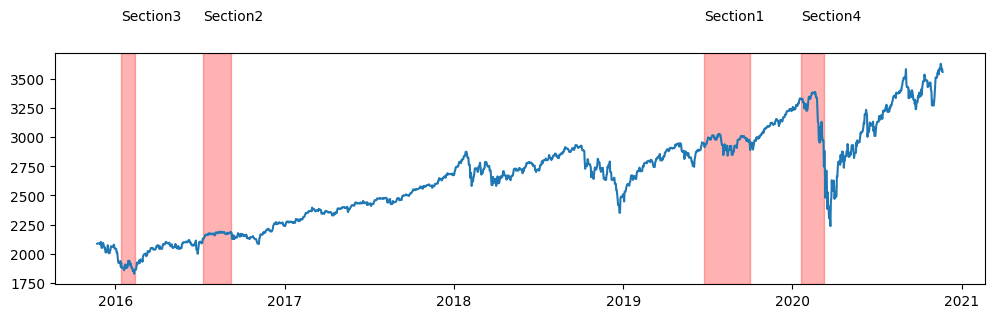

In [6]:
ts = time_series

random.seed(42)
ts_missing = []
ts_missing_len = [100,60,30,50]
for i in range(len(ts_missing_len)):
    start = random.randint(0, len(ts))
    ts_missing.append((start,start+ts_missing_len[i]))

plt.figure(figsize=(12,3))
plt.plot(ts)
for i,section in enumerate(ts_missing):
    plt.axvspan(ts.index[section[0]],ts.index[section[1]],color='red', alpha=0.3)
    plt.text(ts.index[section[0]],4000,f'Section{i+1}')
plt.show()

In [7]:
train = pd.DataFrame(ts)
train.columns = ['y_true']
train['y'] = train['y_true']
for section in ts_missing:
    train.iloc[range(section[0],section[1]),1]=np.nan
train.shape

(1825, 2)

In [8]:
def plot_imputaion(show_ci = True, title=''):
    plt.subplots(len(ts_missing),1,figsize=(12,len(ts_missing)*2))
    plt.suptitle(title)
    for i,section in enumerate(ts_missing):
        plt.subplot(len(ts_missing),1,i+1)
        plot_df = train.iloc[range(section[0]-30,section[1]+30),:]
        plt.plot(plot_df['y_mean'], label='imputed')
        plt.plot(plot_df['y_true'], label='true')
        if show_ci:
            plt.fill_between(plot_df.index,plot_df['y_mean'] + 3*plot_df['y_std'],
                             plot_df['y_mean'] - 3*plot_df['y_std'], alpha=0.3,
                            label='99% confidence interval')
        plt.title(f"Section {i+1} RMSE:{round((mean_squared_error(plot_df['y_mean'],plot_df['y_true']))**(1/2),2)}")
        plt.axvspan(ts.index[section[0]],ts.index[section[1]],color='red', alpha=0.1)
        plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

## Заполнение с помощью последнего наблюдаемого значения

<ipython-input-9-62f933c06460>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['y_mean'] = train['y'].fillna(method='ffill')


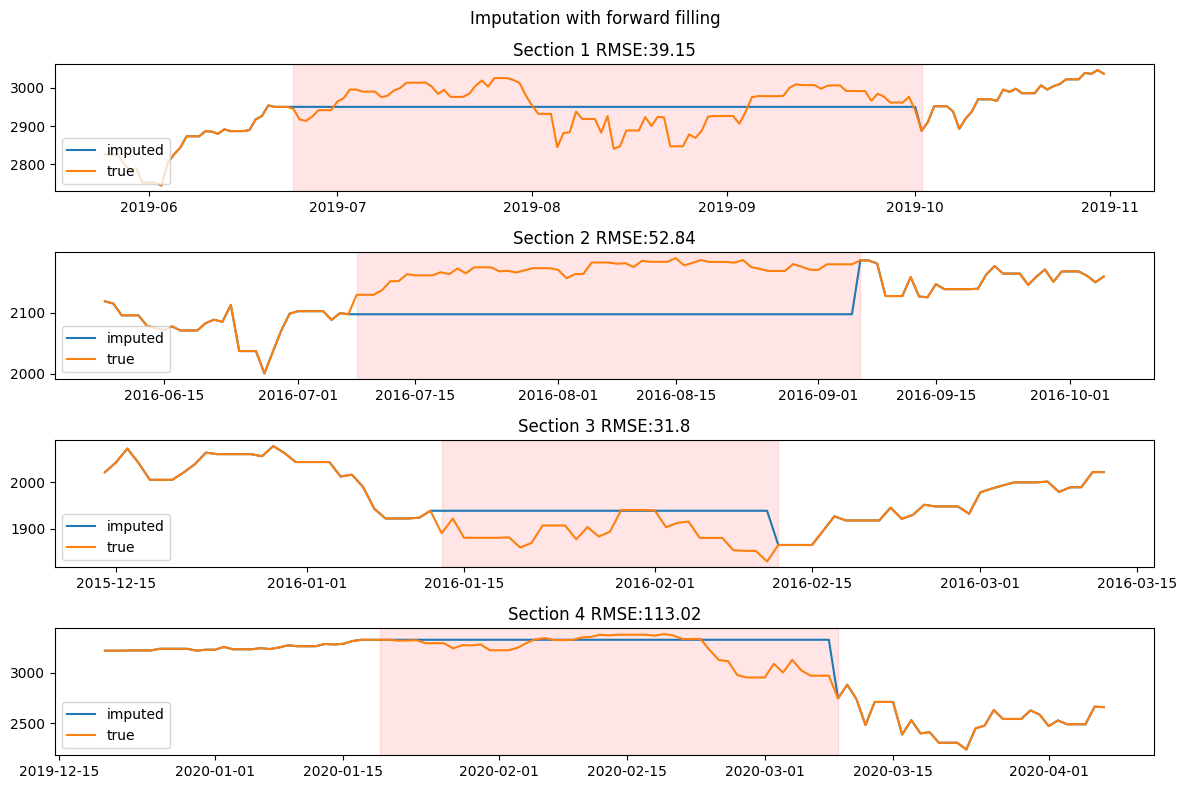

In [9]:
train['y_mean'] = train['y'].fillna(method='ffill')
train['y_std'] = 0
plot_imputaion(show_ci=False, title='Imputation with forward filling')

## Заполнение с помощью интерполяции

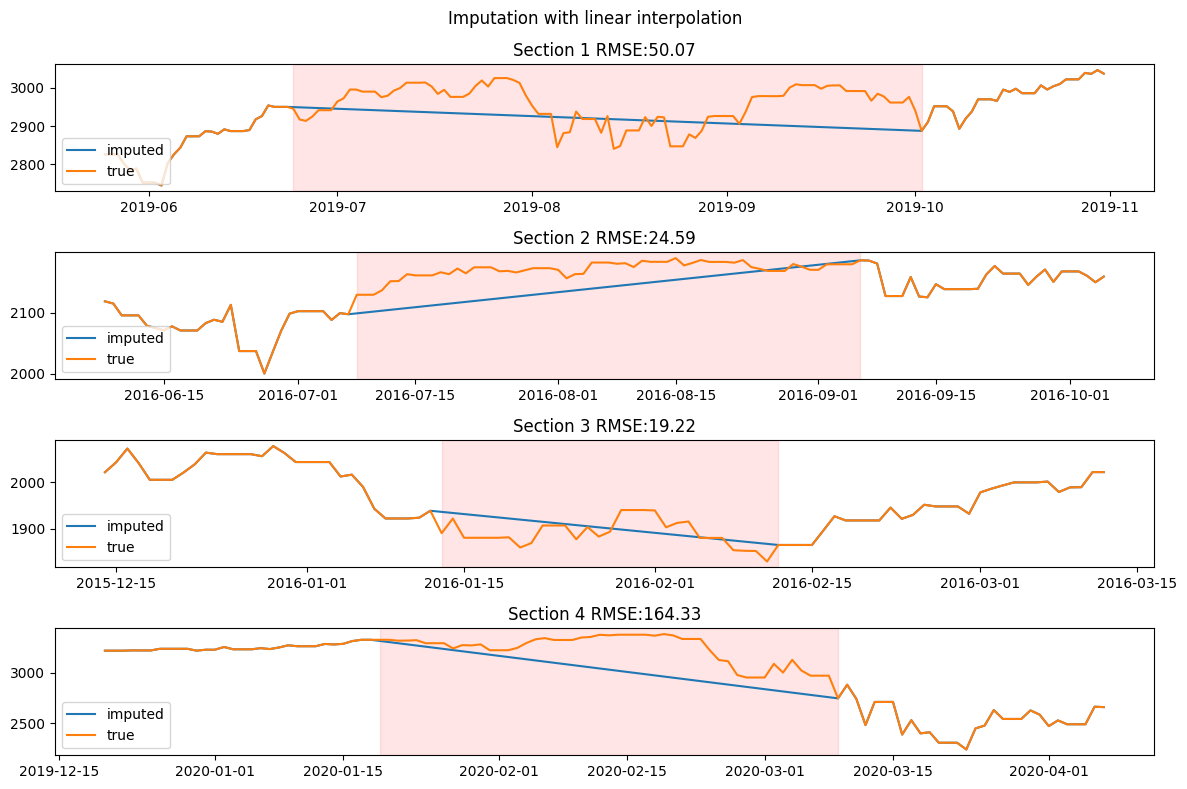

In [10]:
train['y_mean'] = train['y'].interpolate(method='linear')
train['y_std'] = 0

plot_imputaion(show_ci=False, title='Imputation with linear interpolation')

## Заполнение с помощью регрессии

In [11]:
%%time

win_size = 60
X = sliding_window_view(train['y'].values,win_size)

#add the month info
X = np.concatenate((X, train.index.month.values[:len(X)].reshape(-1,1)), axis=1)

imp = IterativeImputer()
X_imp = imp.fit_transform(X)

CPU times: user 19.1 s, sys: 111 ms, total: 19.2 s
Wall time: 17.4 s


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [12]:
matrix = X_imp[:,range(win_size)]
diags = [matrix[::-1,:].diagonal(i) for i in range(-matrix.shape[0]+1,matrix.shape[1])]

train['y_mean'] = np.nan
train['y_std'] = np.nan

for i,v in enumerate(diags):
    train.iloc[i,2] = np.mean(v)
    train.iloc[i,3] = np.std(v)

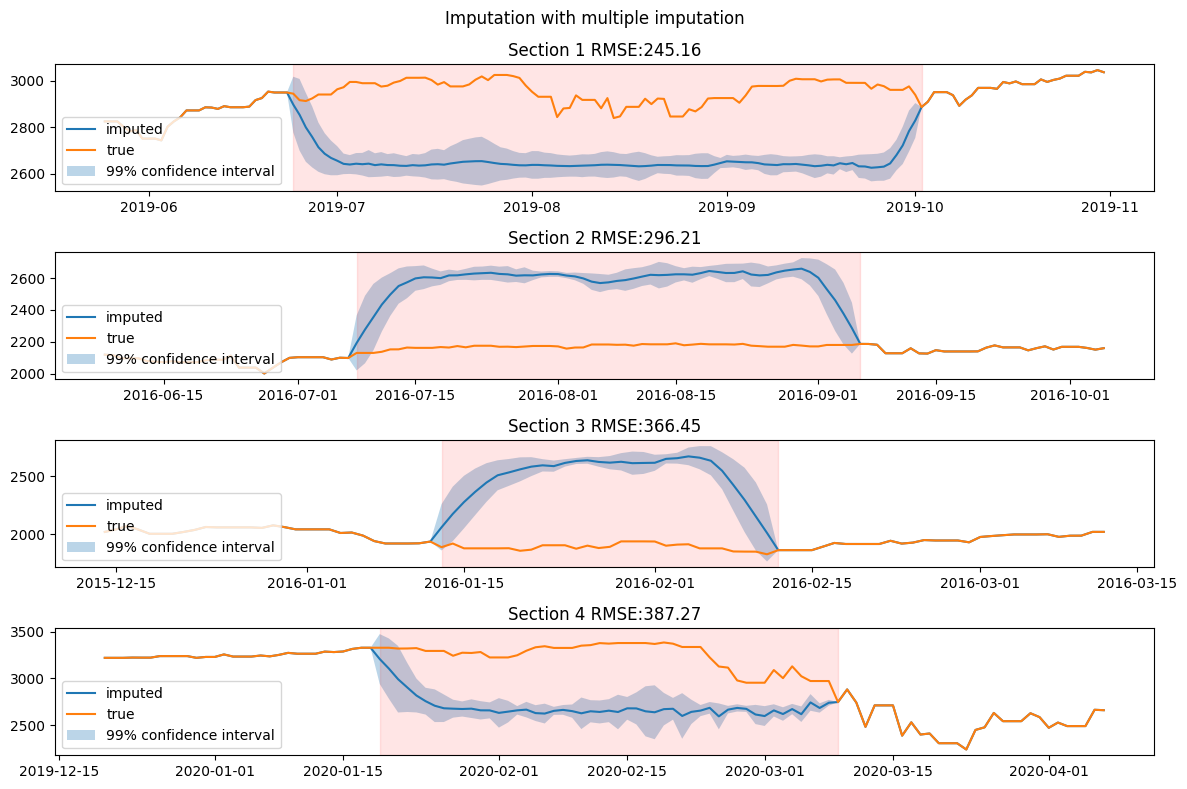

In [13]:
plot_imputaion(title='Imputation with multiple imputation')

## Заполнение с помощью гауссовского процесса

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,RationalQuadratic

In [15]:
def gaussian_regression(X_train,Y_train, X):
    noise = 0.25
    kernel = ConstantKernel(1.0) * RBF(length_scale=20.0)
    # kernel = ConstantKernel(10.0) * RationalQuadratic(alpha=1,length_scale=20)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise, normalize_y=True)
    gpr.fit(X_train, Y_train)
    mu, std = gpr.predict(X, return_std=True)
    return mu, std

g_train = train[['y']].copy()
g_train['x'] = np.arange(0,len(train))
g_train = g_train.dropna()
g_train.shape

train['y_mean'], train['y_std']  = gaussian_regression(g_train['x'].values.reshape(-1, 1),
                              g_train['y'],  np.arange(0,len(train)).reshape(-1, 1))

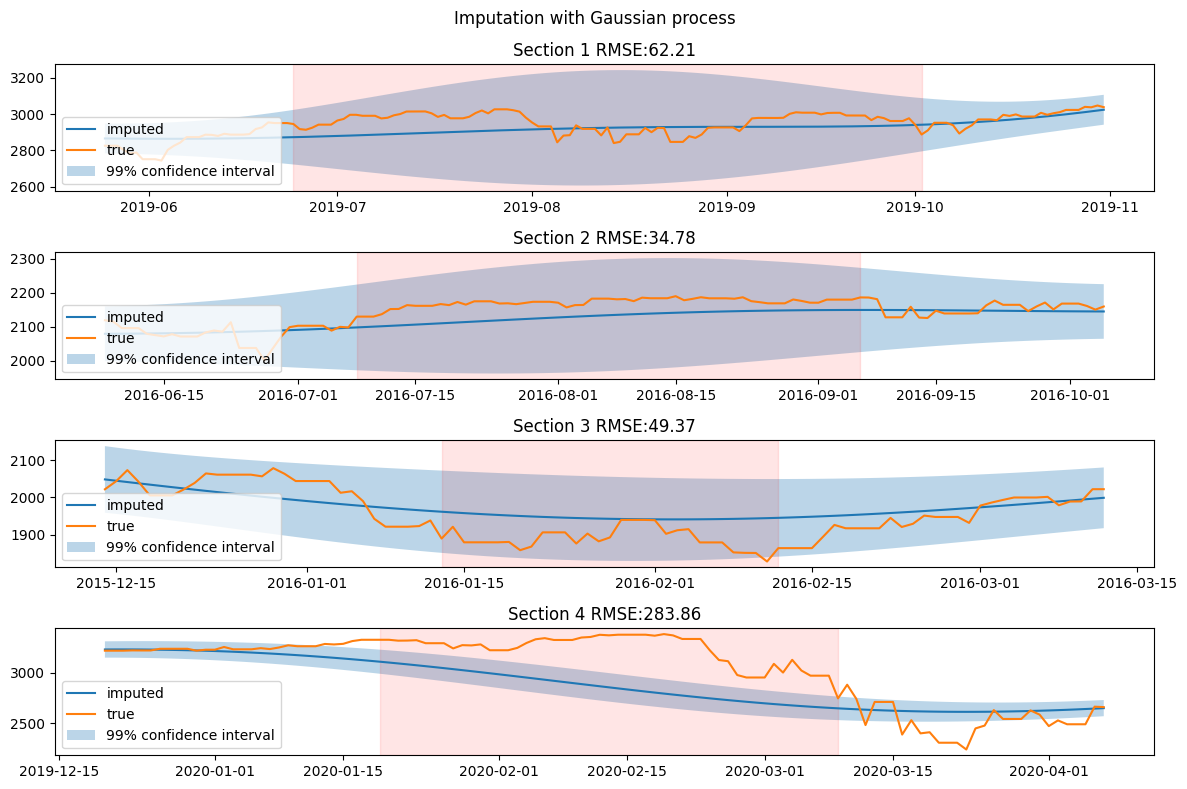

In [16]:
plot_imputaion(title='Imputation with Gaussian process')

## Заполнение с прогнозированием на основе Theta-модел

In [17]:
from statsmodels.tsa.forecasting.theta import ThetaModel

In [18]:
start = 0
train['y_mean'] = train['y'].copy()
train['y_std'] = 0

for section in sorted(ts_missing):
    val = train['y'].values[start:section[0]]
    tm = ThetaModel(endog=val, period=7)
    res = tm.fit()
    pred = res.forecast(section[1]-section[0])
    #save prediction to y_mean
    train.iloc[section[0]:section[1],2] = pred
    start = section[1]

assert train['y_mean'].isna().sum()==0

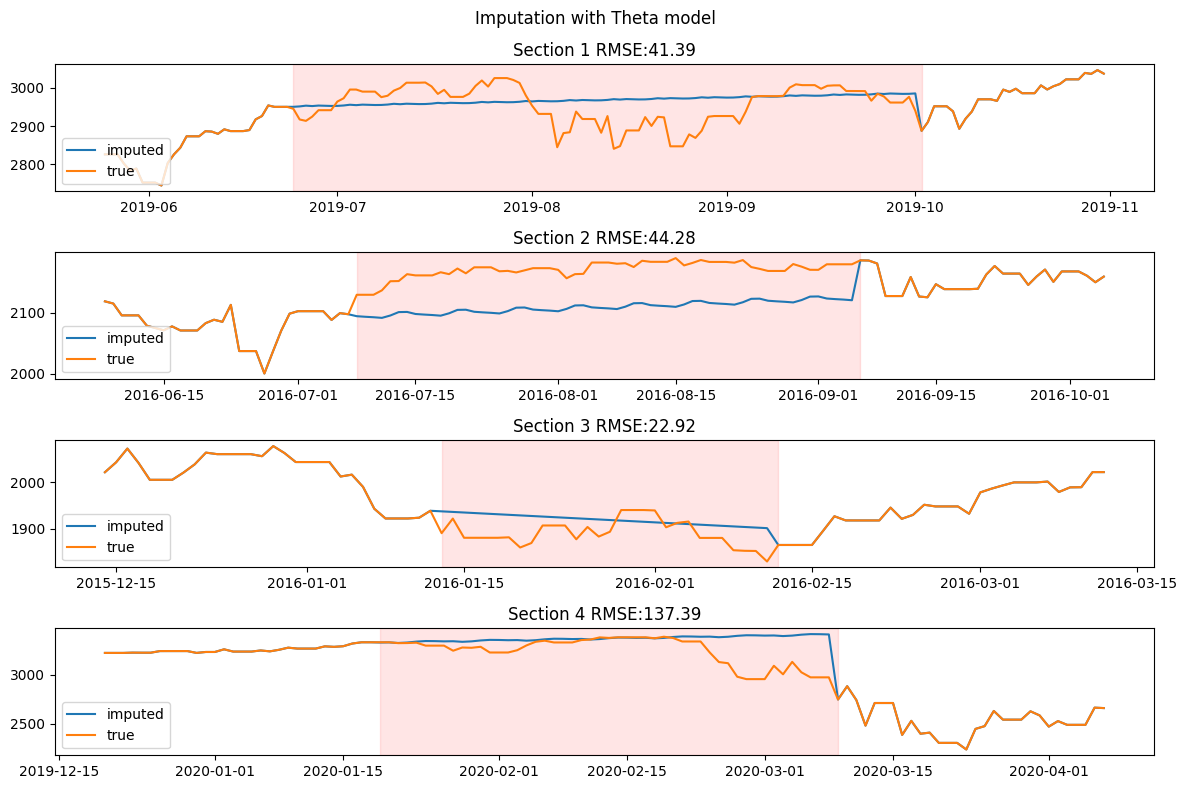

In [19]:
plot_imputaion(show_ci=False, title='Imputation with Theta model')